In [3]:
import numpy as np
import pandas as pd
import healpy as hp
import GCRCatalogs
import os, sys
from GCR import GCRQuery
from sqlalchemy import create_engine
import mog_utils
import units
import matplotlib.pyplot as plt
from lsst.sims.utils import angularSeparation

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = None

## Surface brightness of SN host galaxies

Author: Ji Won Park (@jiwoncpark) via discussions with Rahul Biswas (@rbiswas4)

Last Run: 4/30/2019

- __Objective__: To find a distribution of the surface brightness of the host galaxy at the location of the SNe in the DDF region.
- __Motivation__: Image subtraction is used to detect the SN. As can be seen in Fig 10 of [Kessler et al 2015](https://arxiv.org/pdf/1507.05137.pdf), however, the precision of the DES image subtraction algorithm gets worse with surface brightness between 20.5 and 22. This is because the high surface brightness causes the background to be bright and reduces the contrast of SN against the background. We want to ensure that DC2 includes this range of background brightness so as to test the performance of our image subtraction in the challenging environment. 
- __Assumptions__: 
    - While the background is technically the PSF-convolved brightness of all nearby galaxies summed over, for simplicity we use the PSF-convolved host galaxy brightness as a proxy for background.
    - CosmoDC2 models galaxies as de Vaucouleurs bulge plus exponential disk. We use the prescription in [Hogg and Lang 2013](https://arxiv.org/abs/1210.6563) to approximate each component (bulge or disk) as a mixture of Gaussians so that PSF convolution can be made analytical.
    - We use a circular Gaussian PSF with FWHM 0.7".
    - Assuming that the instance catalogs use unlensed conventions for the SN position (needs confirming), we calculate the host surface brightness using unlensed quantities from CosmoDC2.

### 1-2. Read in prefetched catalog of host galaxy and SN quantities

See notebook `host_surface_brightness.ipynb` in the same directory to learn how to fetch this catalog. Here, we simply read one in.

In [4]:
hostgal_sn_path = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/ddf_region_galaxy_catalog/DDF_sn_host_pairs.csv'
hostgal_sn = pd.read_csv(hostgal_sn_path, index_col=False)

# This subset of columns correspond to SN columns
sn_columns = ['galaxy_id', 'htmid_level_6', 'c_in', 'mB', 't0_in', 'x0_in', 'x1_in', 'z_in', 'snid_in', 'snra_in', 'sndec_in']
sn = hostgal_sn[sn_columns].copy()

### 3. Approximate each host galaxy as a Gaussian mixture to enable analytic PSF convolution

Note: `MoG` stands for "mixture of Gaussians."

In [5]:
# Format catalog with unit conversions and column renaming
hostgal_formatted = mog_utils._format_extragal_catalog(hostgal_sn)
#hostgal_formatted.columns

In [6]:
# Separate galaxy catalog into bulge and disk --> params of 2 Sersics
bulge, disk, _ = mog_utils.separate_bulge_disk(hostgal_formatted)
#bulge.head()

In [7]:
# Deconstruct bulge/disk into MoG --> Params of 18 Gaussians
bulge_mog = mog_utils.sersic_to_mog(sersic_df=bulge, bulge_or_disk='bulge')
disk_mog = mog_utils.sersic_to_mog(sersic_df=disk, bulge_or_disk='disk')
#bulge_mog.head(20)

In [8]:
# Concat bulge and disk MoGs
full_mog = pd.concat([bulge_mog, disk_mog], axis=0)

In [9]:
# Apply circular PSF
nominal_PSF = 0.7 # fwhm in arcsec
full_mog['gauss_sigma'] += units.fwhm_to_sigma(nominal_PSF)**2.0

### 4. Evaluate the surface brightness at the location of SN

In [10]:
# Join MoG df with SN df to get information about SN

full_mog_sn = full_mog.merge(sn, how='left', on='galaxy_id')

In [11]:
full_mog_sn.columns

Index(['galaxy_id', 'ra', 'dec', 'e', 'phi', 'gauss_sigma', 'flux_u', 'flux_g',
       'flux_r', 'flux_i', 'flux_z', 'flux_Y', 'htmid_level_6', 'c_in', 'mB',
       't0_in', 'x0_in', 'x1_in', 'z_in', 'snid_in', 'snra_in', 'sndec_in'],
      dtype='object')

In [12]:
# Get ra, dec offset in arcsec of the SN from host galaxy center
dec_in_radians = np.deg2rad(units.arcsec_to_deg(full_mog_sn['dec'].values))
full_mog_sn['ra_offset'] = (units.deg_to_arcsec(full_mog_sn['snra_in'].values) - full_mog_sn['ra'].values)*np.cos(dec_in_radians)
full_mog_sn['dec_offset'] = units.deg_to_arcsec(full_mog_sn['sndec_in'].values) - full_mog_sn['dec'].values

In [13]:
# Evaluate each Gaussian at the offset (SN location)

# Pre-fetch some columns
sigmas = full_mog_sn['gauss_sigma'].values
ellips = full_mog_sn['e'].values
phis = full_mog_sn['phi'].values
ra_offsets = full_mog_sn['ra_offset'].values
dec_offsets = full_mog_sn['dec_offset'].values

profiles = {}
for bp in 'ugrizY':
    # Create a 2D elliptical Gaussian surface brightness profile for each component of MoG
    profile_bp = mog_utils.get_2d_gaussian(flux_array=full_mog_sn['flux_%s' %bp].values,
                                           sigma_array=sigmas, ellip_array=ellips, phi_array=phis)
    # Evaluate surface brightness at SN location
    full_mog_sn['sb_%s' %bp] = profile_bp(ra_offsets, dec_offsets)
    #full_mog_sn['sb_%s' %bp] = profile_bp(0.5, 0.5)
    profiles[bp] = profile_bp

In [14]:
# Sum across Gaussisan components
sb_all_bands = full_mog_sn.groupby(['galaxy_id',])[['sb_%s' %bp for bp in 'ugrizY']].sum()
sb_all_bands.head()

,sb_u,sb_g,sb_r,sb_i,sb_z,sb_Y
galaxy_id,,,,,,
1250000121,1.389688,4.509560,7.063084,8.748124,9.696141,10.451796
1250000621,0.309514,0.988154,1.814200,2.555619,3.256615,3.824639
1250001962,0.000003,0.000014,0.000032,0.000046,0.000059,0.000069
1250002033,0.467065,1.713005,2.940691,3.820274,4.506172,4.994778
1250004772,0.322235,0.997013,1.901771,2.683098,3.404478,4.038988


In [15]:
# Convert flux into mag
for bp in 'ugrizY':
    sb_all_bands['mag_sb_%s' %bp] = units.flux_to_mag(sb_all_bands['sb_%s' %bp].values, from_unit='nMgy')

/global/u1/j/jwp/DC2/SN_image_catalog_validation/surface_brightness/units.py:6: RuntimeWarning: divide by zero encountered in log10
  return zeropoint_mag - 2.5*np.log10(flux)


In [16]:
# Drop infinite mags (zero fluxes)
with pd.option_context('mode.use_inf_as_null', True):
    finite_sb_all_bands = sb_all_bands.dropna()

### 3. Visualize

Surface brightness is very very dim. Could the problem be the distance from SN to host center?

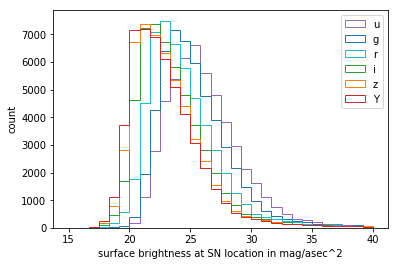

In [58]:
color_dict = {'u': 'tab:purple', 'g': 'tab:blue', 'r': 'tab:cyan', 'i': 'tab:green', 'z': 'tab:orange', 'Y': 'tab:red'}
for bp in 'ugrizY':
    plt.hist(finite_sb_all_bands['mag_sb_%s' %bp], range=[15.0, 40.0], histtype='step', color=color_dict[bp], label=bp, bins=30)
    #plt.hist(finite_sb_all_bands['mag_sb_%s' %bp], range=[15.0, 40.0], histtype='step', color=color_dict[bp], label=bp, bins=30)
plt.legend()
plt.xlabel("surface brightness at SN location in mag/asec^2")
#plt.xlabel("surface brightness ~0.5asec away in RA, Dec from center in mag/asec^2")
plt.ylabel("count")
plt.savefig('host_surface_brightness_at_sn_locations.pdf')

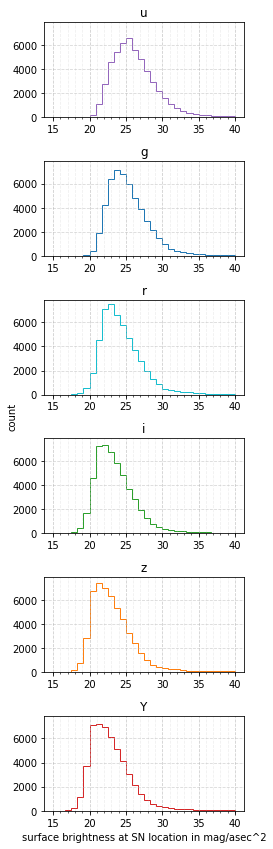

In [76]:
fig, ax = plt.subplots(6, sharex=False, sharey=True, figsize=(4, 12))
fig.add_subplot(111, frameon=False)
x_major_ticks = np.arange(15, 40.5, 5)
x_minor_ticks = np.arange(15, 40.5, 1)
y_ticks = np.arange(0, 8000, 2000)

for ax_idx, bp in enumerate('ugrizY'):
    _ = ax[ax_idx].hist(finite_sb_all_bands['mag_sb_%s' %bp], range=[15.0, 40.0], histtype='step', color=color_dict[bp], label=bp, bins=30)
    ax[ax_idx].set_title(bp)
    ax[ax_idx].set_xticks(major_ticks)
    ax[ax_idx].set_xticks(minor_ticks, minor=True)
    ax[ax_idx].set_yticks(y_ticks)
    ax[ax_idx].grid(which='major', alpha=0.5, linestyle='--')
    ax[ax_idx].grid(which='minor', alpha=0.2, linestyle='--')
    
fig.tight_layout()
plt.xlabel("surface brightness at SN location in mag/asec^2")
plt.ylabel("count")
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.savefig('per_band_host_surface_brightness_at_sn_locations.pdf')

How far are the SNs from the host galaxy center? Seems far...

Text(0.5,0,'distance from SN to host center in arcsec')

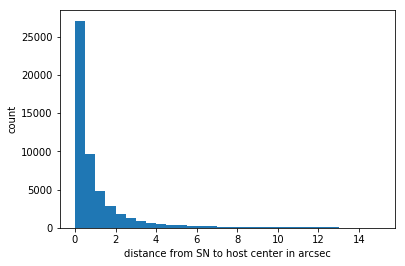

In [22]:
simple_join = hostgal_sn
ra_host = units.arcsec_to_deg(simple_join['ra'].values)
dec_host = units.arcsec_to_deg(simple_join['dec'].values)
ra_sn = simple_join['snra_in'].values
dec_sn = simple_join['sndec_in'].values
angular_sep = angularSeparation(ra_host, dec_host, ra_sn, dec_sn) # deg
_ = plt.hist(units.deg_to_arcsec(angular_sep), bins=30, range=(0, 15))
plt.ylabel("count")
plt.xlabel("distance from SN to host center / hlr of host")
plt.ylabel("count")
plt.xlabel("distance from SN to host center in arcsec")

In [28]:
full_mog_sn.columns

Index(['galaxy_id', 'ra', 'dec', 'e', 'phi', 'gauss_sigma', 'flux_u', 'flux_g',
       'flux_r', 'flux_i', 'flux_z', 'flux_Y', 'htmid_level_6', 'c_in', 'mB',
       't0_in', 'x0_in', 'x1_in', 'z_in', 'snid_in', 'snra_in', 'sndec_in',
       'ra_offset', 'dec_offset', 'sb_u', 'sb_g', 'sb_r', 'sb_i', 'sb_z',
       'sb_Y'],
      dtype='object')

How many HLRs away from the host center are the SNs?
Too many... problem!

Text(0.5,0,'distance from SN to host center / effective radius of host')

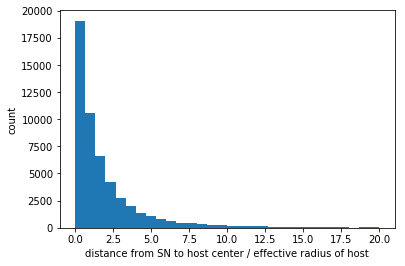

In [24]:
effective_bulge_radius = (simple_join['size_bulge_true'].values*simple_join['size_minor_bulge_true'].values)**0.5
effective_disk_radius = (simple_join['size_disk_true'].values*simple_join['size_minor_disk_true'].values)**0.5
bulge_ratio = simple_join['bulge_to_total_ratio_i']
effective_total_radius = effective_bulge_radius*bulge_ratio + effective_disk_radius*(1.0 - bulge_ratio)

_ = plt.hist(units.deg_to_arcsec(angular_sep)/effective_total_radius, bins=30, range=(0, 20))
plt.ylabel("count")
plt.xlabel("distance from SN to host center / effective radius of host")

Host magnitude for reference

Text(0,0.5,'count')

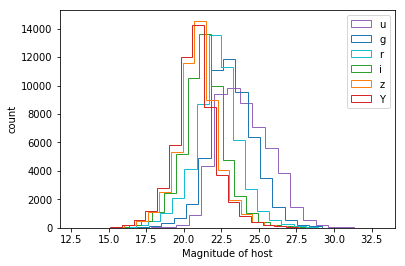

In [29]:
for bp in 'ugrizY':
    plt.hist(simple_join['mag_true_%s_lsst' %bp], histtype='step', color=color_dict[bp], label=bp, bins=20)
    #plt.hist(finite_sb_all_bands['mag_sb_%s' %bp], range=[15.0, 40.0], histtype='step', facecolor=color_dict[bp], label=bp, bins=30)
plt.legend()
plt.xlabel("Magnitude of host")
plt.ylabel("count")

### 4. (Further check) Compare Sersic vs. MoG profiles without PSF